In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
def get_loaders_MNIST(batch_size=100):
    transforms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = tv.datasets.MNIST(root="./data/", train=True, download=True, transform=transforms)
    test_data = tv.datasets.MNIST(root="./data/", train=False, download=True, transform=transforms)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [2]:
def get_loaders_CIFAR(batch_size=100):
    transform_train = tv.transforms.Compose([
        tv.transforms.RandomCrop(32, padding=4),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    transform_test = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
  
    train_data = tv.datasets.CIFAR10(root="./data/", train=True, download=True, transform=transform_train)
    test_data = tv.datasets.CIFAR10(root="./data/", train=False, download=True, transform=transform_test)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader



In [3]:
def plot_features(feature, targets, epoch, save_path):
    color = ["red", "black", "yellow", "green", "pink", "gray", "lightgreen", "orange", "blue", "teal"]
    cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    plt.ion()
    plt.clf()
    for j in cls:
        mask = targets == j
        feature_ = feature[mask].numpy()
        x = feature_[:, 1]
        y = feature_[:, 0]
        plt.plot(x, y, ".", color=color[j])
    
    plt.legend(cls, loc="upper right")
    plt.title("epoch={}".format(str(epoch+1)))
    plt.savefig('{}/{}.jpg'.format(save_path, epoch+1))
    plt.show()

In [4]:
def testdata_accuracy(net, arcnet, test_loader):
    acc = 0
    for i, (x, y) in enumerate(test_loader):
        latent_out = net(x)
        arc_out = torch.log(arcnet(latent_out))
        value = torch.argmax(arc_out, dim=1)
        acc += torch.sum((value == y).float())
    print('test accuracy = ', acc.item() / len(test_loader.dataset))

In [5]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(64, 16, 3, 2, 1),
            nn.ReLU()
        )
        self.linear_layer = nn.Linear(16*4*4, latent_dim)
        
    def forward(self, xs):
        cnn_out = self.cnn_layers(xs)
        flatten = cnn_out.reshape(-1, 16*4*4)
        latent_out = self.linear_layer(flatten)
        return latent_out
    

In [6]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, num_classes, latent_dim, s=20, m=0.1):
        super().__init__()
        self.s = s
        self.m = torch.tensor(m)
        self.w = nn.Parameter(torch.rand(latent_dim, num_classes))
    
    def forward(self, embedding):
        embedding = F.normalize(embedding, dim=1)
        w = F.normalize(self.w, dim=0)
        cos_theta = torch.matmul(embedding, w) / self.s
        sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
        cos_theta_m = cos_theta * torch.cos(self.m) - sin_theta * torch.sin(self.m)
        cos_theta_scaled = torch.exp(cos_theta * self.s)
        sum_cos_theta = torch.sum(torch.exp(cos_theta * self.s), dim=1, keepdim=True) - cos_theta_scaled
        top = torch.exp(cos_theta_m * self.s)
        arcout = top / (top + sum_cos_theta)
        return arcout

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.stop = False

    def __call__(self, test_accuracy):
        score = test_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_score = score
            self.counter = 0


Files already downloaded and verified
Files already downloaded and verified
test accuracy =  0.299
Epoch [1/50], Training Loss: 3.9447, Training Accuracy: 23.26%
test accuracy =  0.3587
Epoch [2/50], Training Loss: 3.7001, Training Accuracy: 32.44%
test accuracy =  0.3848
Epoch [3/50], Training Loss: 3.6460, Training Accuracy: 37.03%
test accuracy =  0.395
Epoch [4/50], Training Loss: 3.6213, Training Accuracy: 38.85%
test accuracy =  0.4074
Epoch [5/50], Training Loss: 3.6011, Training Accuracy: 40.34%
test accuracy =  0.4342
Epoch [6/50], Training Loss: 3.5851, Training Accuracy: 42.11%
test accuracy =  0.4298
Epoch [7/50], Training Loss: 3.5745, Training Accuracy: 42.90%
test accuracy =  0.4431
Epoch [8/50], Training Loss: 3.5618, Training Accuracy: 44.27%
test accuracy =  0.459
Epoch [9/50], Training Loss: 3.5566, Training Accuracy: 44.60%
test accuracy =  0.4667
Epoch [10/50], Training Loss: 3.5475, Training Accuracy: 45.13%
test accuracy =  0.4679
Epoch [11/50], Training Loss: 3.

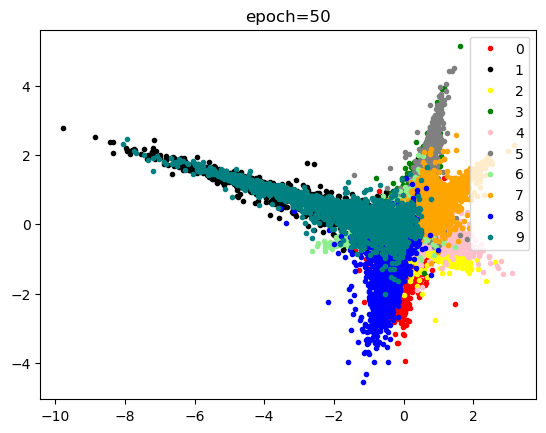

Model saved successfully!


In [8]:
def train_model():
    latent_dim = 3
    num_classes = 10
    net = ImageFeatureExtractor(latent_dim)
    arcnet = ArcFaceClassifier(num_classes, latent_dim)
    arcloss = nn.NLLLoss(reduction="mean")
    optimizerarc = torch.optim.SGD([{'params': net.parameters()}, {'params': arcnet.parameters()}], lr=0.01, momentum=0.9, weight_decay=0.0005)
    scheduler = ReduceLROnPlateau(optimizerarc, 'min', patience=3, verbose=True)
    save_pic_path = "./Images"
    train_loss = []
    test_accuracy = []
    num_epochs = 50
    train_loader, test_loader = get_loaders_CIFAR()
    
    os.makedirs(save_pic_path, exist_ok=True)
    
    early_stopping = EarlyStopping(patience=5, delta=0.01)  # Stop if accuracy hasn't improved by 1% in the last 10 epochs
    
    for epoch in range(num_epochs):
        net.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        embeddings = []
        targets = []
        
        for i, (x, y) in enumerate(train_loader):
            latent_out = net(x)
            arc_out = torch.log(arcnet(latent_out))
            loss = arcloss(arc_out, y)
            optimizerarc.zero_grad()
            loss.backward()
            optimizerarc.step()
            
            total_loss += loss.item()
            predictions = torch.argmax(arc_out, dim=1)
            total_correct += torch.sum(predictions == y).item()
            total_samples += y.size(0)
            
            embeddings.append(latent_out)
            targets.append(y)

        train_accuracy = total_correct / total_samples
        scheduler.step(total_loss / len(train_loader))
        train_loss.append(total_loss / len(train_loader))
        test_accuracy_val = testdata_accuracy(net, arcnet, test_loader)
        early_stopping(test_accuracy_val)

        if early_stopping.stop:
            print("Early stopping triggered!")
            break
        

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, total_loss / len(train_loader), train_accuracy * 100))

        # Visualizing the embeddings
        all_embeddings = torch.cat(embeddings, 0)
        all_targets = torch.cat(targets, 0)
    plot_features(all_embeddings.data.cpu(), all_targets.data.cpu(), epoch, save_pic_path)

    # Saving the trained model
    PATH = "model.pth"
    torch.save(net.state_dict(), PATH)
    print("Model saved successfully!")


# Run the main function
train_model()
